In [1]:
using Pkg
cd("D:\\Home\\Git\\Oceananigans.jl")
# cd("C:\\Users\\Ali\\Documents\\Git\\Oceananigans.jl\\")
Pkg.activate(".");

using Statistics, Printf
using Oceananigans, Oceananigans.Operators

import PyPlot
using Interact, Plots
Plots.gr()

HTML{String}("    <script id=\"webio-setup-15130167225660965077\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-6760304441072052515\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-15130167225660965077\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/28f5f30a59da434290b7f09bd0d0ddea74a5f34e-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-6760304441072052515\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

Plots.GRBackend()

In [2]:
include("src/operators/operators_old.jl")
include("src/equation_of_state_old.jl")

ρ (generic function with 1 method)

In [50]:
const NumType = Float64  # Number data type.
const g = 9.80665  # Standard acceleration due to gravity [m/s²].
const f = 1e-4  # Nominal value for the Coriolis frequency [rad/s].
const χ = 0.1  # Adams-Bashforth (AB2) parameter.

Nˣ, Nʸ, Nᶻ = 100, 1, 100
Lˣ, Lʸ, Lᶻ = 4000, 2000, 4000  # Domain size [m].

Nᵗ = 10000
Δt = 10  # Time step [s].

Δx, Δy, Δz = Lˣ/Nˣ, Lʸ/Nʸ, Lᶻ/Nᶻ  # Grid spacing [m].
Aˣ, Aʸ, Aᶻ = Δy*Δz, Δx*Δz, Δx*Δy  # Cell face areas [m²].
V = Δx*Δy*Δz  # Volume of a cell [m³].
M = ρ₀*V  # Mass of water in a cell [kg].

xC = Δx/2:Δx:Lˣ
yC = Δy/2:Δy:Lʸ
zC = -Δz/2:-Δz:-Lᶻ

uⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in x-direction [m/s].
vⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in y-direction [m/s].
wⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Velocity in z-direction [m/s].
Tⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Potential temperature [K].
Sⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Salinity [g/kg].
pʰʸ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ) # Hydrostatic pressure [Pa].
pⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Pressure [Pa].
ρⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)  # Density [kg/m³].

Gᵘⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

Gᵘⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ⁻¹ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

Gᵘⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵛⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gʷⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gᵀⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
Gˢⁿ⁺ʰ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

pʰʸ′ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
pⁿʰ⁺ˢ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
g′ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)
δρ = Array{NumType, 3}(undef, Nˣ, Nʸ, Nᶻ)

uⁿ .= 0; vⁿ .= 0; wⁿ .= 0; Sⁿ .= 35;

# Tⁿ = repeat(reshape(T_ref, 1, 1, 50), Nˣ, Nʸ, 1)
Tⁿ .= 283

pHY_profile = [-ρ₀*g*h for h in zC]
pʰʸ = repeat(reshape(pHY_profile, 1, 1, Nᶻ), Nˣ, Nʸ, 1)
pⁿ = copy(pʰʸ)  # Initial pressure is just the hydrostatic pressure.

ρⁿ .= ρ.(Tⁿ, Sⁿ, pⁿ);

# Tⁿ[Int(Nˣ/2)-5:Int(Nˣ/2)+5, 1, 10-2:10+5] .= 283.01

# hot_buble_perturbation = reshape(0.01 * exp.(-100 * ((xC .- Lˣ/2).^2 .+ (zC .+ Lᶻ/2)'.^2) / (Lˣ^2 + Lᶻ^2)), (Nˣ, Nʸ, Nᶻ))
# @. Tⁿ = 282.99 + 2*hot_buble_perturbation

# rr = rand(Nˣ, Nʸ, Nᶻ)
# Tⁿ[:, 1, 1:round(Int, Nᶻ/2)]   .= 282.99 .+ 0.001.*rr[:, 1, 1:round(Int, Nᶻ/2)]
# Tⁿ[:, 1, round(Int, Nᶻ/2):end] .= 283.01 .+ 0.001.*rr[:, 1, round(Int, Nᶻ/2):end]

rr = rand(Nˣ, Nʸ, Nᶻ)
uⁿ[:, 1, 1:round(Int, Nᶻ/2)]   .=  0.1
uⁿ[:, 1, round(Int, Nᶻ/2):end] .= -0.1
Tⁿ[:, 1, 1:round(Int, Nᶻ/2)]   .= 283.1
Tⁿ[:, 1, round(Int, Nᶻ/2):end] .= 282.9

Fᵀ = zeros(Nˣ, Nʸ, Nᶻ)
# @. Fᵀ[Int(Nˣ/10):Int(9Nˣ/10), 1, 1] = -0.5e-5 + 1e-6*rand()

ΔR = 10
Ru = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# Rv = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
Rw = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
RT = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# RS = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
Rρ = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)
# RpHY′ = Array{NumType, 4}(undef, Nᵗ, Nˣ, Nʸ, Nᶻ)
RpNHS = Array{NumType, 4}(undef, Int(Nᵗ/ΔR), Nˣ, Nʸ, Nᶻ)

κʰ = 4e-2  # Horizontal Laplacian heat diffusion [m²/s]. diffKhT in MITgcm.
κᵛ = 4e-2  # Vertical Laplacian heat diffusion [m²/s]. diffKzT in MITgcm.

𝜈ʰ = 4e-2  # Horizontal eddy viscosity [Pa·s]. viscAh in MITgcm.
𝜈ᵛ = 4e-2  # Vertical eddy viscosity [Pa·s]. viscAz in MITgcm.

function time_stepping(uⁿ, vⁿ, wⁿ, Tⁿ, Sⁿ, pⁿ, pʰʸ, pʰʸ′, pⁿʰ⁺ˢ, g′, ρⁿ, δρ, Gᵘⁿ, Gᵛⁿ, Gʷⁿ, Gᵀⁿ, Gˢⁿ, Gᵘⁿ⁻¹, Gᵛⁿ⁻¹, Gʷⁿ⁻¹, Gᵀⁿ⁻¹, Gˢⁿ⁻¹, Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ, Gᵀⁿ⁺ʰ, Gˢⁿ⁺ʰ)
    for n in 1:Nᵗ
        # Calculate new density and density deviation.
        @. δρ = ρ(Tⁿ, Sⁿ, pⁿ) - ρ₀
        @. ρⁿ = ρ₀ + δρ
        
        δρ̅ᶻ = avgᶻc2f(δρ)
        for j in 1:Nʸ, i in 1:Nˣ
          pʰʸ′[i, j, 1] = δρ[i, j, 1] * g * Δz / 2
        end
        for k in 2:Nᶻ, j in 1:Nʸ, i in 1:Nˣ
          pʰʸ′[i, j, k] = pʰʸ′[i, j, k-1] + (δρ̅ᶻ[i, j, k] * g * Δz)
        end
        
        Gᵘⁿ⁻¹ = Gᵘⁿ; Gᵛⁿ⁻¹ = Gᵛⁿ; Gʷⁿ⁻¹ = Gʷⁿ; Gᵀⁿ⁻¹ = Gᵀⁿ; Gˢⁿ⁻¹ = Gˢⁿ;

        # Gᵘⁿ .= -(1/Δx) .* δˣc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²u(uⁿ)
        # Gᵛⁿ .= -(1/Δy) .* δʸc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²v(vⁿ)
        # Gʷⁿ .=                                 𝜈ᵛ∇²w(wⁿ)
        Gᵘⁿ .= .- ũ∇u(uⁿ, vⁿ, wⁿ) .+ f .* avgʸc2f(avgˣf2c(vⁿ)) .- (1/Δx) .* δˣc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²u(uⁿ)
        Gᵛⁿ .= .- ũ∇v(uⁿ, vⁿ, wⁿ) .- f .* avgˣc2f(avgʸf2c(uⁿ)) .- (1/Δy) .* δʸc2f(pʰʸ′ ./ ρ₀) .+ 𝜈ʰ∇²v(vⁿ)
        Gʷⁿ .= -ũ∇w(uⁿ, vⁿ, wⁿ)                                .+ 𝜈ᵛ∇²w(wⁿ)
        Gᵀⁿ .= -div_flux_f2c(uⁿ, vⁿ, wⁿ, Tⁿ) .+ κ∇²(Tⁿ) + Fᵀ
        Gˢⁿ .= -div_flux_f2c(uⁿ, vⁿ, wⁿ, Sⁿ) .+ κ∇²(Sⁿ)
        
        @. begin
            Gᵘⁿ⁺ʰ = (3/2 + χ)*Gᵘⁿ - (1/2 + χ)*Gᵘⁿ⁻¹
            Gᵛⁿ⁺ʰ = (3/2 + χ)*Gᵛⁿ - (1/2 + χ)*Gᵛⁿ⁻¹
            Gʷⁿ⁺ʰ = (3/2 + χ)*Gʷⁿ - (1/2 + χ)*Gʷⁿ⁻¹
            Gᵀⁿ⁺ʰ = (3/2 + χ)*Gᵀⁿ - (1/2 + χ)*Gᵀⁿ⁻¹
            Gˢⁿ⁺ʰ = (3/2 + χ)*Gˢⁿ - (1/2 + χ)*Gˢⁿ⁻¹
        end
        
        RHS = div_f2c(Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ)  # Right hand side or source term.
        pⁿʰ⁺ˢ = solve_poisson_3d_ppn(RHS, Nˣ, Nʸ, Nᶻ, Δx, Δy, Δz)
        
#         RHS_rec = laplacian3d_ppn(pⁿʰ⁺ˢ) ./ (Δx)^2  # TODO: This assumes Δx == Δy == Δz.
#         error = RHS_rec .- RHS
#         @info begin
#             string("Fourier-spectral solver diagnostics:\n",
#                     @sprintf("RHS:     min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS), maximum(RHS), mean(RHS), mean(abs.(RHS)), std(RHS)),
#                     @sprintf("RHS_rec: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(RHS_rec), maximum(RHS_rec), mean(RHS_rec), mean(abs.(RHS_rec)), std(RHS_rec)),
#                     @sprintf("error:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(error), maximum(error), mean(error), mean(abs.(error)), std(error))
#                     )
#         end
        
        @. pⁿ = pʰʸ′ + pⁿʰ⁺ˢ

        uⁿ .= uⁿ .+ ( Gᵘⁿ⁺ʰ .- (1/Δx) .* δˣc2f(pⁿʰ⁺ˢ) ) .* Δt
        vⁿ .= vⁿ .+ ( Gᵛⁿ⁺ʰ .- (1/Δy) .* δʸc2f(pⁿʰ⁺ˢ) ) .* Δt
        wⁿ .= wⁿ .+ ( Gʷⁿ⁺ʰ .- (1/Δz) .* δᶻc2f(pⁿʰ⁺ˢ) ) .* Δt

        @. Sⁿ = Sⁿ + (Gˢⁿ⁺ʰ * Δt)
        @. Tⁿ = Tⁿ + (Gᵀⁿ⁺ʰ * Δt)
        
        div_u1 = div_f2c(uⁿ, vⁿ, wⁿ)
        
        if n % ΔR == 0
            print("\rt=$(n*Δt)/$(Nᵗ*Δt)")
#             @info begin
#             string("Time: $(n*Δt)\n",
#                    @sprintf("uⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(uⁿ), maximum(uⁿ), mean(uⁿ), mean(abs.(uⁿ)), std(uⁿ)),
#                    @sprintf("vⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(vⁿ), maximum(vⁿ), mean(vⁿ), mean(abs.(vⁿ)), std(vⁿ)),
#                    @sprintf("wⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(wⁿ), maximum(wⁿ), mean(wⁿ), mean(abs.(wⁿ)), std(wⁿ)),
#                    @sprintf("Tⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(Tⁿ), maximum(Tⁿ), mean(Tⁿ), mean(abs.(Tⁿ)), std(Tⁿ)),
#                    @sprintf("Sⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(Sⁿ), maximum(Sⁿ), mean(Sⁿ), mean(abs.(Sⁿ)), std(Sⁿ)),
#                    @sprintf("pʰʸ:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pʰʸ), maximum(pʰʸ), mean(pʰʸ), mean(abs.(pʰʸ)), std(pʰʸ)),
#                    @sprintf("pʰʸ′: min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pʰʸ′), maximum(pʰʸ′), mean(pʰʸ′), mean(abs.(pʰʸ′)), std(pʰʸ′)),
#                    @sprintf("pⁿʰ⁺ˢ:min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pⁿʰ⁺ˢ), maximum(pⁿʰ⁺ˢ), mean(pⁿʰ⁺ˢ), mean(abs.(pⁿʰ⁺ˢ)), std(pⁿʰ⁺ˢ)),
#                    @sprintf("pⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(pⁿ), maximum(pⁿ), mean(pⁿ), mean(abs.(pⁿ)), std(pⁿ)),
#                    @sprintf("ρⁿ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(ρⁿ), maximum(ρⁿ), mean(ρⁿ), mean(abs.(ρⁿ)), std(ρⁿ)),
#                    @sprintf("δρ:   min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(δρ), maximum(δρ), mean(δρ), mean(abs.(δρ)), std(δρ)),
#                    @sprintf("∇⋅u1:  min=%.6g, max=%.6g, mean=%.6g, absmean=%.6g, std=%.6g\n", minimum(div_u1), maximum(div_u1), mean(div_u1), mean(abs.(div_u1)), std(div_u1))
#                   )
#             end  # @info

            Ridx = Int(n/ΔR)
            Ru[Ridx, :, :, :] = copy(uⁿ)
            # Rv[n, :, :, :] = copy(vⁿ)
            Rw[Ridx, :, :, :] = copy(wⁿ)
            RT[Ridx, :, :, :] = copy(Tⁿ)
            # RS[n, :, :, :] = copy(Sⁿ)
            Rρ[Ridx, :, :, :] = copy(ρⁿ)
            # RpHY′[n, :, :, :] = copy(pʰʸ′)
            RpNHS[Ridx, :, :, :] = copy(pⁿʰ⁺ˢ)
        end
    end
end

time_stepping (generic function with 1 method)

In [51]:
@time time_stepping(uⁿ, vⁿ, wⁿ, Tⁿ, Sⁿ, pⁿ, pʰʸ, pʰʸ′, pⁿʰ⁺ˢ, g′, ρⁿ, δρ, Gᵘⁿ, Gᵛⁿ, Gʷⁿ, Gᵀⁿ, Gˢⁿ, Gᵘⁿ⁻¹, Gᵛⁿ⁻¹, Gʷⁿ⁻¹, Gᵀⁿ⁻¹, Gˢⁿ⁻¹, Gᵘⁿ⁺ʰ, Gᵛⁿ⁺ʰ, Gʷⁿ⁺ʰ, Gᵀⁿ⁺ʰ, Gˢⁿ⁺ʰ)

t=100000/100000107.252157 seconds (1.11 G allocations: 162.739 GiB, 15.76% gc time)


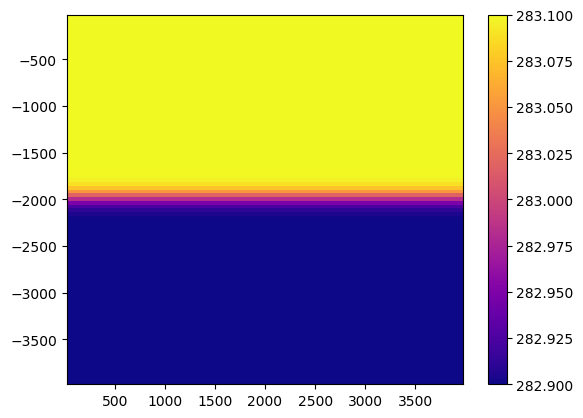

In [53]:
PyPlot.pcolormesh(xC, zC, rotr90(RT[end, :, 1, :]), cmap="plasma"); PyPlot.colorbar();

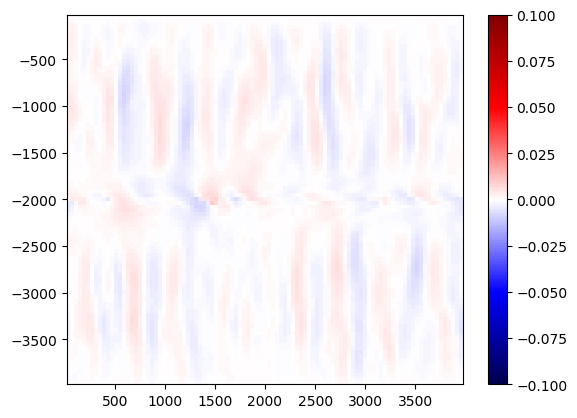

In [32]:
PyPlot.pcolormesh(xC, zC, rotr90(Rw[end, :, 1, :]), vmin=-0.1, vmax=0.1, cmap="seismic"); PyPlot.colorbar();

In [33]:
anim = @animate for tidx in 1:Int(Nᵗ/ΔR)
    print("\rframe = $tidx / $(Int(Nᵗ/ΔR))   ")
    Plots.heatmap(xC, zC, rotl90(RT[tidx, :, 1, :]) .- 283, color=:plasma,
        clims=(-0.01, 0.01),
        # clims=(-maximum(RT[tidx, :, 1, :] .- 283), maximum(RT[tidx, :, 1, :] .- 283)),
        title="T change @ t=$(tidx*ΔR*Δt)")
end
mp4(anim, "tracer_T_$(round(Int, time())).mp4", fps = 30)

frame = 1000 / 1000   

┌ Info: Saved animation to 
│   fn = D:\Home\Git\Oceananigans.jl\tracer_T_1545261430.mp4
└ @ Plots C:\Users\Ali\.julia\packages\Plots\y6yik\src\animation.jl:90


Plots.AnimatedGif("D:\\Home\\Git\\Oceananigans.jl\\tracer_T_1545261430.mp4")